# ESfunfuzz——针对JavaScript引擎的一致性缺陷检测系统
- 基于差分模糊测试的思想，通过构造大量测试用例输入到多个JavaScript引擎中进行差分测试的方式来对引擎的一致性缺陷进行检测；
- 通过从ECMA-Script262标准文档中自动解析出的有效的语义信息来指导用例进行定向突变，使得用例能够覆盖引擎的更多分支，从而提高检测效率。


<img src="Images/整体流程概述.png" style="zoom:50%; float:left;" />


### 阶段一：语法标准解析
通过自定义的标准解析器，从ECMAScript-262标准文档中解析出有效的语义信息，并存入语义数据库，用于后续指导用例突变；
<br>
<br>
<br>

### 阶段二：生成模型构建
首先从GitHub上获取到大量的JavaScript文件，并将其经过预处理后构成语料库，并利用该语料库训练一个基于神经语言模型的代码生成模型，用于后续生成用例；
<br>
<br>
<br>

### 阶段三：差分模糊测试
收集各个引擎的回归测试用例构成种子池，每次从池中随机选择一个种子用例，并分别对其进行定向突变和续写生成，得到新用例；并对新用例进行差分模糊测试，以获得触发引擎不一致行为的可疑用例；最后对可疑用例进行人工分析，以确定引擎缺陷。循环此过程以便于对引擎进行长期的测试。

## 注意事项
此Jupyter笔记本仅对ESfunfuzz系统的**核心环节——差分模糊测试阶段**（包括用例突变、用例续写、差分模糊测试、实验信息统计）进行小规模的演示，**第一、二阶段将被略过**；假如你需要长期的进行实际测试，请使用配套提供的Docker命令行；

本文件作为标准的演示文件，**请不要直接执行或修改本文件**。

## 如何开始
首先请先返回主页，点击 `main.ipynb` 的选中框，然后点击上方的 `Duplicate` 按钮， 创建一个拷贝文件；之后进入该文件，依次点击 `Kernel` -> `Restart & Clear Output` 清空之前的记录；之后依次点击 `Cell` -> `Run All` 按钮，即可开始整个文件的演示运行；又或者你可以点击某个具体的单元格，点击播放按钮来运行它（注意，有些单元依赖于正在执行的前一个单元。如果出现任何错误，请确保执行了之前的所有单元格）。

某些Cell可能需要几分钟才能完成，运行后请耐心等待结果，之后再进入下一个单元。

## Step1.测试用例生成
### Step1.1 随机从种子池中选择种子用例
用例生成的第一个步骤就是从种子池中随机挑选一个种子用例。然而，由于种子用例选取具有较大随机性，且会直接影响后续的用例生成和模糊测试过程。因此，为了保证后续步骤的演示效果，此处我们人工设定了**一个固定的种子用例，该用例与论文第三章保持一致。**

In [1]:
from CodeGenerator.conf import hparams
from Fuzzer.testcase import DataBase

# 建立数据库连接，从中挑选出一个随机的种子用例
database = DataBase(hparams.seed_pool_url)
seed_testcase = database.get_a_record_randomly().testcase

# 人工设定一个固定的种子用例
seed_testcase = """var NISLFuzzingFunc = function() {
    var temp = Number(1).toString("Hello"); 
    print(temp);
}
NISLFuzzingFunc();"""

print(f'本次选择的种子用例为：\n{seed_testcase}')

本次选择的种子用例为：
var NISLFuzzingFunc = function() {
    var temp = Number(1).toString("Hello"); 
    print(temp);
}
NISLFuzzingFunc();


### Step1.2 测试用例定向突变
接下来将开始针对该种子用例进行定向突变，首先分析该用例中的相关API，并查询语义数据库，获得与该用例相关的语义信息。此步骤对应于论文第三章。

查询结果包含以下字段:
- name: 传递给JS API的参数名称
- type: 参数的潜在类型（由ESfunfuzz根据标准判断）
- conditions: 与API输入参数相关的条件语句
- scope: 根据条件语句判断出的参数候选范围
- values: 根据参数候选范围确定的该参数的候选值

In [2]:
from CaseMutator.mutator import Mutator

new_testcases = []

# 打印语义信息
print('该用例相关的语义信息如下：')
mutator = Mutator()
query_result = mutator.get_semantic_info(seed_testcase)
mutator.print_info(query_result)

该用例相关的语义信息如下：
Number.prototype.toString:
{
    "name": "radix",
    "type": "integer",
    "conditions": [
        "radix === undefined",
        "radix === undefined",
        "radix < 2",
        "radix > 36",
        "radix === 10"
    ],
    "scopes": [
        2,
        36
    ],
    "values": [
        "undefined",
        10,
        1,
        37,
        7,
        "NaN",
        0,
        "Infinity",
        "-Infinity"
    ]
}
Number:
{
    "name": "value",
    "type": "number",
    "conditions": [],
    "scopes": [],
    "values": []
}


接着，根据查询到的语义信息对用例做定向突变，生成若干新用例。

In [3]:
# 用例突变
mutated_testcases = mutator.mutate(seed_testcase)
new_testcases += mutated_testcases

print("突变生成的新测试用例如下：")
for i in mutated_testcases:
    print('=' * 50)
    print(i)

突变生成的新测试用例如下：
var NISLFuzzingFunc = function (nislMutationParameter0) {
    var temp = Number(1).toString(nislMutationParameter0);
    print(temp);
};
var nislMutationArgument0 = "-";
NISLFuzzingFunc(nislMutationArgument0);
var NISLFuzzingFunc = function (nislMutationParameter0) {
    var temp = Number(1).toString(nislMutationParameter0);
    print(temp);
};
var nislMutationArgument0 = 37;
NISLFuzzingFunc(nislMutationArgument0);
var NISLFuzzingFunc = function (nislMutationParameter0) {
    var temp = Number(nislMutationParameter0).toString('Hello');
    print(temp);
};
var nislMutationArgument0 = 298389;
NISLFuzzingFunc(nislMutationArgument0);
var NISLFuzzingFunc = function (nislMutationParameter0) {
    var temp = Number(1).toString(nislMutationParameter0);
    print(temp);
};
var nislMutationArgument0 = 1028797;
NISLFuzzingFunc(nislMutationArgument0);
var NISLFuzzingFunc = function (nislMutationParameter0) {
    var temp = Number(nislMutationParameter0).toString('Hello');
    print(t

### Step1.3 测试用例续写生成
第二种产生新用例的方式就是使用模型对用例进行自动续写。此步骤对应于论文第四章。

In [4]:
import os
import torch

from CodeGenerator.utils import load_json, syntax_check
from CodeGenerator.sample import sample_solo

device = torch.device(f"cuda:{hparams.gpu}" if torch.cuda.is_available() else "cpu")

# 读取工作路径和训练词汇表
print("正在恢复词汇表和模型，请稍等...")
workspace_path = os.path.dirname(hparams.gen_model)
token_to_idx = load_json(os.path.join(workspace_path, 'token_to_idx.json'))
idx_to_token = load_json(os.path.join(workspace_path, 'idx_to_token.json'), transfer=True)

# 恢复模型
model = torch.load(hparams.gen_model, map_location=f'cuda:{hparams.gpu}').to(device)
model.device = device

# 续写生成新用例
while True:
    generated_testcase = sample_solo(model=model,
                             prefix=seed_testcase + 'var ',
                             max_gen_length=hparams.max_gen_length,
                             token_to_idx=token_to_idx,
                             idx_to_token=idx_to_token,
                             segment_length=hparams.segment_length,
                             new_line_number=hparams.new_line_number,
                             temperature=hparams.temperature,
                             sample=hparams.sample)
    if syntax_check(generated_testcase):
        break

new_testcases.append(generated_testcase)
print('=' * 60)
print('模型续写生成的新用例为：')
print(generated_testcase)

正在恢复词汇表和模型，请稍等...
模型续写生成的新用例为：
var NISLFuzzingFunc = function() {
    var temp = Number(1).toString("Hello"); 
    print(temp);
}
NISLFuzzingFunc();var test = new Function('this.foo = 1'); test('foo', function () { return test(); }); test('foo', function () { return test(function () { return test(); }).toString(); }); test('foo bar test foo', function () { assert.equal(test.foo, 1); }); test('foo bar', function () { assert.equal(test(), 'foo'); }); test('foo', function () { assert.equal(test(false), 'foo'); }); test('foo', function () { assert.equal(test(false), false); }); test('foo', function () { assert.equal(test(false), false); }); test('fails', function () { assert.equal(test, false); }); test('fails with a function', function () { assert.equal(fail, false); }); test('fails', function () { assert.equal(false, false); }); test('fails that a new fails', function () { assert.equal(false, false); }); test('fail', function () { assert.fail(function () { fn(); }, TypeError); }); test('

此时，我们使用定向突变和模型续写这两种方法生成了多个新用例，接着将会对这些用例进行差分模糊测试。

## Step2.差分模糊测试
### Step2.1 引擎执行
用例生成的第一个步骤就是从种子池中随机挑选一个种子用例。然而，由于种子用例选取具有较大随机性，且会直接影响后续的用例生成和模糊测试过程。因此，为了保证后续步骤的演示效果，此处我们人工设定了。**此步骤对应于论文章节4.4.2**。

In [5]:
from tqdm import tqdm

from Fuzzer.fuzzer import Fuzzer, Result

def blue_print(str):
    print(f"\033[1;34;48m{str}\033[0m")


# 配置待测引擎和单个用例的最大执行时间
hparams.engines = [
    "/root/.jsvu/sm",
    "/root/.jsvu/jsc",
    "/root/.jsvu/v8",
    "/root/.jsvu/jerryscript-2.1.0/build/bin/jerry"
]
hparams.timeout = 15

#
fuzzer = Fuzzer(hparams.engines, hparams.timeout)


# 依次对新生成的用例进行差分模糊测试
print('正在对新生成的用例进行差分模糊测试，请等待...')
for testcase in tqdm(new_testcases):
    new_fuzzing_result = fuzzer.run_testcase_multi_threads(testcase)
    
    # 假如某个用例触发了引擎的不一致行为，则立即停止（仅演示用，平常检测时不会停止）
    if new_fuzzing_result.is_suspicious():
        print('====发现可疑用例，该用例为：====\n')
        print(testcase)
        print('=' * 60)
        break

# 展示该可疑用例
print('该用例的执行结果如下：')
for output in new_fuzzing_result.outputs:
    blue_print(f'- 引擎名称：{output.engine_name}, 结果类别： {output.output_class}')
    print(f'- 返回值：  {output.returncode}')
    print(f'- 标准输出：{output.stdout.strip()}')
    print(f'- 标准错误：{output.stderr.strip()}')
    print('=' * 60)

  0%|          | 0/19 [00:00<?, ?it/s]

正在对新生成的用例进行差分模糊测试，请等待...


 21%|██        | 4/19 [00:01<00:05,  2.83it/s]

====发现可疑用例，该用例为：====

var NISLFuzzingFunc = function (nislMutationParameter0) {
    var temp = Number(nislMutationParameter0).toString('Hello');
    print(temp);
};
var nislMutationArgument0 = null;
NISLFuzzingFunc(nislMutationArgument0);
该用例的执行结果如下：
- 引擎名称：spidermonkey, 结果类别： runtime_error
- 返回值：  3
- 标准输出：
- 标准错误：/tmp/javascriptTestcase_kumz_t4s.js:2:47 RangeError: radix must be an integer at least 2 and no greater than 36
Stack:
  NISLFuzzingFunc@/tmp/javascriptTestcase_kumz_t4s.js:2:47
  @/tmp/javascriptTestcase_kumz_t4s.js:6:16
- 引擎名称：jsc, 结果类别： runtime_error
- 返回值：  3
- 标准输出：Exception: RangeError: toString() radix argument must be between 2 and 36
toString@[native code]
NISLFuzzingFunc@/tmp/javascriptTestcase_kumz_t4s.js:2:55
global code@/tmp/javascriptTestcase_kumz_t4s.js:6:16
- 标准错误：
- 引擎名称：v8, 结果类别： runtime_error
- 返回值：  1
- 标准输出：/tmp/javascriptTestcase_kumz_t4s.js:2: RangeError: toString() radix argument must be between 2 and 36
    var temp = Number(nislMutationParameter0).t

通过对该用例的执行结果进行观察，可以发现Jerry引擎的执行结果类别为 `pass(通过)`，与其余引擎的 `runtime_error(运行时异常)` 不一致，因此即该用例属于可疑用例，需要进行后续操作。

### Step2.2 种子池扩充
发现可疑用例后，需要根据该用例的执行行为判断是否需要将该用例扩充进种子池。**此步骤对应于论文章节4.4.3**。

判断的依据是论文中提到的“状态码判重法”，将每个引擎执行用例的行为细分为9个状态，并将其组合成为该用例最终的状态码，比较状态码在种子池中是否出现过来判断该用例是否重复。

In [6]:
new_fuzzing_testcase = Result.result_map_to_testcase(new_fuzzing_result, hparams.timeout, 0)

print('=' * 60)
print('各个引擎执行结果的状态码如下：')
for output in new_fuzzing_result.outputs:
    print(f'- 引擎名称：{output.engine_name}, 结果类别： {output.output_class}， 状态码为：{output.get_state_code()}')
    
print('=' * 60)
blue_print(f'因此，该用例最终的状态码为：{new_fuzzing_testcase.state_code}')

各个引擎执行结果的状态码如下：
- 引擎名称：spidermonkey, 结果类别： runtime_error， 状态码为：4
- 引擎名称：jsc, 结果类别： runtime_error， 状态码为：4
- 引擎名称：v8, 结果类别： runtime_error， 状态码为：4
- 引擎名称：jerry, 结果类别： pass， 状态码为：1
因此，该用例最终的状态码为：4441


之后，查询种子池判断该状态码是否已存在：
- 假如已存在，则该用例被认定为重复，丢弃；
- 假如不存在，则该用例被认定为有效，该用例将会加入到种子池中；

（注意：此处为了有效演示，我们注释掉了向种子池中加入该用例的代码，使得该用例一直都是有效的）

In [7]:
# 根据状态码判重
if database.compare_and_filter(new_fuzzing_testcase):
    # database.add(new_fuzzing_testcase)
    blue_print('该状态码在种子池中不存在，用例有效，已加入种子池')
    
else:
    blue_print('该状态码在种子池中已存在，用例无效，丢弃')

该状态码在种子池中不存在，用例有效，已加入种子池


## Step3.人工分析

当可疑用例被认定为有效，则需要对其进行人工分析，以确定其是否真的为引擎缺陷。人工分析主要包括用例精简、缺陷定位、标准推演以及编写并提交报告等四个步骤：
1. 首先需要根据执行结果对用例进行不断地精简，直到能够定位到触发引擎不一致行为的具体代码；
2. 随后查询ES标准，定位到该代码对应到标准中的具体条目；
3. 之后人工按照标准的内容进行推导，以得到标准规定的预期行为；
4. 最后将其实际行为与预期行为进行作对比，若引擎行为不符合标准预期，则说明该引擎在实现上确实存在缺陷，接着便编写缺陷报告，提交给开发商，等待后续确认；若一致，则说明本次属于误报，故跳过。

**这一部分对应于论文章节4.4.4**。

## Step4.实验评估
Step1到Step3展现了使用ESfunfuzz系统对JavaScript引擎进行差分模糊测试的完整流程。而Step4将展示论文所进行的实验评估及其结果，**对应于论文第五章**。

### Step4.1 语言模型调优实验
生成用例的质量将直接决定检测方法的效果。本文有两种用例生成方法，其中，基于标准文档分析的突变式方法由于是直接在语法树级别操作，所以一定不会带来语法错误，故不需要调优；而用例续写生成方法由于是使用神经语言模型进行自动续写的，可能会导致生成语法不正确的用例，对模糊测试的效率影响较大，因此需要对其进行调优。

语言模型调优主要考虑数据的编码级别。编码级别是指在将训练数据编码成向量的过程中，基于怎样的粒度来进行切分。本文选择了字符（Char）级别、词级别（Word）以及字节对编码（Byte-pair-encoding, BPE）等三种不同级别进行实验，观察模型在不同级别下的表现。**此步骤对应于论文章节5.3.2**。

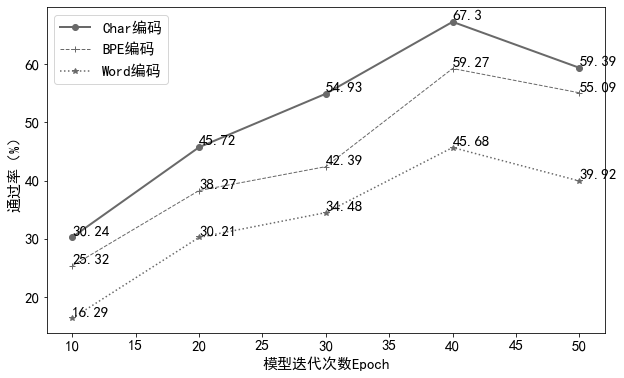

In [8]:
from Evaluation.Chapter_5_3_2.plot import plot
plot()

### Step4.2 与其他工具的对比实验
为了进一步验证本文方法的效果，需要将ESfunfuzz与当前最先进的其他模糊测试工具进行对比实验。本实验主要关注两个方面，即生成用例的质量以及缺陷检测的能力。本文选择的对比对象有四个，分别是Fuzzilli、CodeAlchemist、Montage和DIE，对它们的具体介绍参考章节1.2，它们都是近几年来最先进的针对于JavaScript引擎的模糊测试工具，与它们进行对比可以充分说明ESfunfuzz的有效性。

#### Step4.2.1 生成用例质量对比
生成用例的质量主要通过两方面来衡量，其一是用例的通过率，通过率越高则意味着测试效率越高；其二是代码覆盖率，代码覆盖率表示测试用例被执行到了多少，覆盖率越高说明用例的利用率越高，就也有可能触发引擎缺陷。覆盖率可以进一步细化为三种类型，即行覆盖率、分支覆盖率和方法覆盖率，分别表示语句行、条件分支和方法被执行到了多少，通过它们能对用例的质量进行一个比较全面的衡量。**此步骤对应于论文章节5.4.1**。

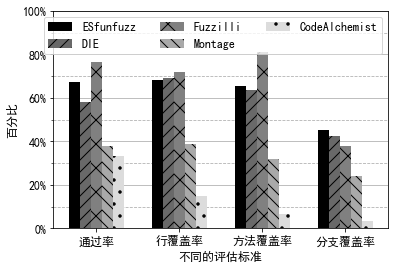

In [9]:
from Evaluation.Chapter_5_4_1.plot import plot
plot()

#### Step4.2.2 缺陷检测能力对比
评估一个模糊测试工具的缺陷检测能力，最直接且有效的方法就是统计其在一定时间内发现的引擎缺陷的数量，因此还将通过比较各个工具发现的缺陷个数来衡量ESfunfuzz系统的缺陷检测能力。本实验的具体实施步骤是：使用ESfunfuzz与其他四种模糊测试工具分别进行为期72小时的测试过程，并对所有检测出的可疑用例进行人工分析和缺陷提交，分别统计其触发和确认的缺陷个数，个数越多说明其缺陷检测能力越强。**此步骤对应于论文章节5.4.2**。

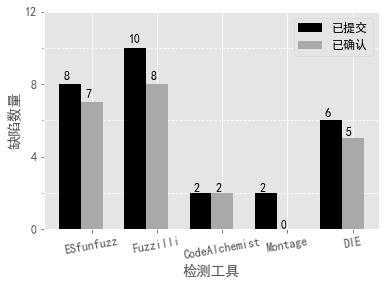

In [10]:
from Evaluation.Chapter_5_4_2.plot import plot
plot()

### Step4.3 真实环境下的缺陷检测实验
本章截止到目前，所安排的实验设置以及实验结果都很好地说明了本文提出的基于差分标准文档分析和差分模糊测试的JavaScript一致性缺陷检测方法的有效性。然而，检验一个模糊测试工具是否有效，并不能仅仅局限于实验环境下，也必须在真实环境下的检测任务中取得成果。因此，笔者将使用本文提出的ESfunfuzz工具对四个主流JavaScript引擎进行一致性缺陷检测，来验证本文方法的有效性。**此步骤对应于论文章节5.5**。

最终，ESfunfuzz成功检测出各类引擎的**一致性缺陷22个**，其中19个得到了开发者确认，具体的检测结果如下所示：

#### ChakraCore

| No.  |   Version   |                             Link                             |       State       |                         Description                          |
| :--: | :---------: | :----------------------------------------------------------: | :---------------: | :----------------------------------------------------------: |
|  1   |  v1.11.12   | [#issue](https://github.com/chakra-core/ChakraCore/issues/6546) |    复现&未修复    |                       重声明变量未报错                       |
|  2   | v1.11.12/24 | [#issue](https://github.com/chakra-core/ChakraCore/issues/6550) |    复现&已修复    |                         this++未报错                         |
|  3   |  V1.11.24   | [#issue](https://github.com/chakra-core/ChakraCore/issues/6553) |    复现&未修复    |                         if(1)未报错                          |
|  6   |   9e2f198   | [#issue](https://github.com/chakra-core/ChakraCore/issues/6567) | 新发现&已修复 |                     重定义TypeError异常                      |
|  7   |   9e2f198   | [#issue](https://github.com/chakra-core/ChakraCore/issues/6569) |    复现&未修复    |              RegExp.prototype.toString实现错误               |
|  9   | 1_11_latest | [#issue](https://github.com/microsoft/ChakraCore/issues/6503) |    复现&未修复    |             %TypedArray%.prototype.sort实现错误              |
|  14  | 1_11_latest |                             None                             |    复现&未修复    |             Proxy对象拦截defineProperty实现错误              |
|  16  | 1_11_latest |                             None                             |    复现&未修复    | RegExp.prototype[Symbol.match]与String.prototype.match不关联 |
|  17  | 1_11_latest | [#issue](https://github.com/chakra-core/ChakraCore/issues/6582) | 新发现&已修复 |       调用Array.prototype.push时不使用自定义的set方法        |
|  20  | 1_11_latest | [#issue](https://github.com/chakra-core/ChakraCore/issues/6589) |     引擎特性      |                   原型链与对象不匹配未报错                   |
|  21  | 1_11_latest | [#issue](https://github.com/chakra-core/ChakraCore/issues/6590) |   新发现&未修复   |                    const声明常量后可修改                     |

#### JavaScriptCore

| No.  |                           Version                            |                           Link                            |       State       |             Description             |
| :--: | :----------------------------------------------------------: | :-------------------------------------------------------: | :---------------: | :---------------------------------: |
|  4   | [d940b47](https://github.com/WebKit/WebKit-http/commit/d940b477848884f63752d25491d9dd0b9d3ccb2d) | [#report](https://bugs.webkit.org/show_bug.cgi?id=220142) |    复现&未修复    |          重声明变量未报错           |
|  8   | [d940b47](https://github.com/WebKit/WebKit-http/commit/d940b477848884f63752d25491d9dd0b9d3ccb2d) |                           None                            |    复现&已修复    |    对freezed对象修改length未报错    |
|  10  | [d940b47](https://github.com/WebKit/WebKit-http/commit/d940b477848884f63752d25491d9dd0b9d3ccb2d) |                           None                            |    复现&已修复    |     同5（需要在JSC新版本验证）      |
|  11  | [d940b47](https://github.com/WebKit/WebKit-http/commit/d940b477848884f63752d25491d9dd0b9d3ccb2d) | [#report](https://bugs.webkit.org/show_bug.cgi?id=220506) |    复现&已修复    |      for...of...语法错误未报错      |
|  12  | [d940b47](https://github.com/WebKit/WebKit-http/commit/d940b477848884f63752d25491d9dd0b9d3ccb2d) | [#report](https://bugs.webkit.org/show_bug.cgi?id=220574) |      待确认       |     已有属性重赋值不调用set方法     |
|  13  | [d940b47](https://github.com/WebKit/WebKit-http/commit/d940b477848884f63752d25491d9dd0b9d3ccb2d) | [#report](https://bugs.webkit.org/show_bug.cgi?id=220507) |    复现&已修复    | %TypedArray%.prototype.sort实现错误 |
|  15  | [d940b47](https://github.com/WebKit/WebKit-http/commit/d940b477848884f63752d25491d9dd0b9d3ccb2d) |                           None                            |    复现&未修复    | Proxy对象拦截defineProperty实现错误 |
|  18  | [d940b47](https://github.com/WebKit/WebKit-http/commit/d940b477848884f63752d25491d9dd0b9d3ccb2d) | [#report](https://bugs.webkit.org/show_bug.cgi?id=220842) |    复现&未修复    |          x与this.x指向不同          |
|  22  | [d940b47](https://github.com/WebKit/WebKit-http/commit/d940b477848884f63752d25491d9dd0b9d3ccb2d) | [#report](https://bugs.webkit.org/show_bug.cgi?id=221177) | 新发现&未修复 |    Array.prototype.push实现异常     |

#### V8

| No.  | Version |                             Link                             | State  |            Description             |
| :--: | :-----: | :----------------------------------------------------------: | :----: | :--------------------------------: |
|  5   | d891c59 | [#report](https://bugs.chromium.org/p/v8/issues/detail?id=11294) | 待确认 | %TypedArray%.prototype.set实现错误 |
|  19  | e39c701 | [#report](https://bugs.chromium.org/p/v8/issues/detail?id=11359) | 待确认 |            new实现异常             |